In [2]:
import numpy as np
from umap import UMAP
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import defaultdict
import os
from sklearn.decomposition import PCA
import scipy
import random
from datetime import datetime
random.seed(8)

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import os
import sys

# Get the current notebook's directory
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(os.path.dirname(current_directory))

# Add the parent directory to the module search path
sys.path.insert(0, parent_directory)
print(parent_directory)

/n/holylabs/LABS/mzitnik_lab/Users/afang/GET


In [11]:
from data.pdb_utils import VOCAB
from openTSNE import TSNE

# Graph embedding of CSD and BioLiP
To see if they occupy different areas of the latent space

## Do different subsets of QBioLIP occupy different areas of the latent space?

In [4]:
color_dict = {
    "PDNA": "#FF5733",  # Red
    "Pion": "#3BB143",  # Green
    "PP": "#3357FF",    # Blue
    "Ppeptide": "#F033FF",  # Magenta
    "RNAL": "#FFC300",  # Yellow
    "PRNA": "#581845",  # Purple
    "PL": "#C70039",    # Maroon
    "CSD": "#FFC0CB"    # Pink
}

In [ ]:
with open("/n/holylabs/LABS/mzitnik_lab/Users/afang/GET/case_studies/visualise_nodes/pretrained_tsne_all/graph_embedding_2d_all_modalities_perplexity_30_20240407.csv", "r") as f:
    df = pd.read_csv(f)

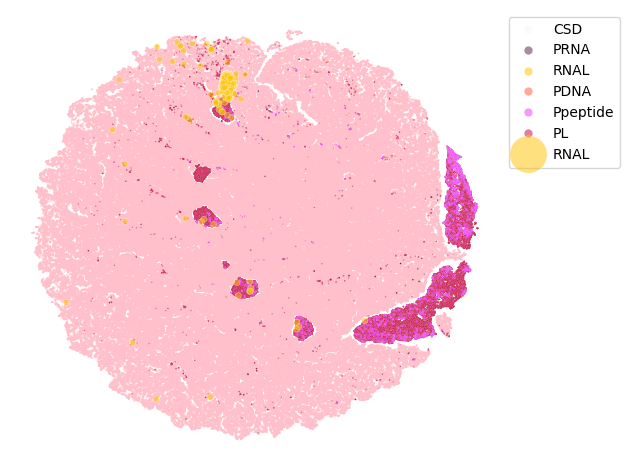

In [11]:
chosen_modality = "RNAL"

ax = sns.scatterplot(
    data=df[df["source"] == "CSD"],
    x="x",
    y="y",
    hue="source",
    palette=color_dict,
    alpha=0.1,
    s=1,
)
sns.scatterplot(
    data=df[df["source"] != "CSD"],
    x="x",
    y="y",
    hue="source",
    palette=color_dict,
    alpha=0.5,
    s=1,
    ax=ax  # This ensures the plot is added to the same axes
)

sns.scatterplot(
    data=df[df["source"] == chosen_modality],
    x="x",
    y="y",
    hue="source",
    palette=color_dict,
    alpha=0.5,
    s=20,
    ax=ax  # This ensures the plot is added to the same axes
)

ax.set(xlabel=None)
ax.set(ylabel=None)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.legend(markerscale=4)
current_date = datetime.now()
formatted_date = current_date.strftime('%Y%m%d')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), markerscale=6)
plt.tight_layout()
# plt.savefig(f"figs/graph_embeddings_{formatted_date}.png", dpi=300)
plt.show()

In [20]:
# Get pairwise distances between different subsets of embeddings
import itertools
import glob
distances = {}
files = glob.glob("/n/holylabs/LABS/mzitnik_lab/Users/afang/GET/case_studies/visualise_nodes/pretrained_embeddings_all/*valid*/graph_embeddings.npy")
graph_embedding_files = dict(zip([f.split("/")[-2] for f in files], files))
pairs = list(itertools.combinations(graph_embedding_files.keys(), 2))
for pair in pairs:
    f1, f2 = pair
    if (f2, f1) in distances:
        continue
    with open(graph_embedding_files[f1], "rb") as f:
        embeddings1 = np.load(f)
    with open(graph_embedding_files[f2], "rb") as f:
        embeddings2 = np.load(f)
    embed1 = embeddings1.mean(axis=0)
    embed2 = embeddings2.mean(axis=0)
    distances[pair] = np.linalg.norm(embed1 - embed2)

In [21]:
sorted(distances.items(), key=lambda x: x[1], reverse=False)

[(('QBioLiP_PRNA_valid', 'QBioLiP_Ppeptide_valid'), 0.06104722),
 (('QBioLiP_Pion_valid', 'QBioLiP_RNAL_valid'), 0.081024915),
 (('QBioLiP_PP_valid', 'QBioLiP_PDNA_valid'), 0.1661152),
 (('QBioLiP_PDNA_valid', 'QBioLiP_Ppeptide_valid'), 0.21608551),
 (('QBioLiP_PRNA_valid', 'QBioLiP_PDNA_valid'), 0.24429573),
 (('QBioLiP_PP_valid', 'QBioLiP_Ppeptide_valid'), 0.34534144),
 (('QBioLiP_PRNA_valid', 'QBioLiP_PP_valid'), 0.3578471),
 (('CSD_valid_PS_300', 'QBioLiP_PL_PS_300_valid'), 0.40151623),
 (('QBioLiP_PRNA_valid', 'QBioLiP_PL_PS_300_valid'), 0.40378585),
 (('QBioLiP_Ppeptide_valid', 'QBioLiP_PL_PS_300_valid'), 0.4391634),
 (('CSD_valid_PS_300', 'QBioLiP_PRNA_valid'), 0.482003),
 (('CSD_valid_PS_300', 'QBioLiP_Ppeptide_valid'), 0.5324569),
 (('QBioLiP_PDNA_valid', 'QBioLiP_PL_PS_300_valid'), 0.6461631),
 (('CSD_valid_PS_300', 'QBioLiP_PDNA_valid'), 0.6575798),
 (('CSD_valid_PS_300', 'QBioLiP_PP_valid'), 0.6643812),
 (('QBioLiP_PP_valid', 'QBioLiP_PL_PS_300_valid'), 0.74379736),
 (('CSD

# Atom embeddings

In [12]:
element_type = {
    'H': 'Nonmetal',
    'B': 'Metalloid',
    'C': 'Nonmetal',
    'N': 'Nonmetal',
    'O': 'Nonmetal',
    'F': 'Halogen',
    'Na': 'Alkali metal',
    'K': 'Alkali metal',

    'Mg': 'Alkaline earth metal',
    'Al': 'Post-transition metal',
    'P': 'Nonmetal',
    'S': 'Nonmetal',
    'Cl': 'Halogen',
    'Ca': 'Alkaline earth metal',
    'V': 'Transition metal',
    'Mn': 'Transition metal',
    'Fe': 'Transition metal',
    'Co': 'Transition metal',
    'Se': 'Nonmetal',
    'Br': 'Halogen',
    'Y': 'Transition metal',
    'Mo': 'Transition metal',
    'Ru': 'Transition metal',
    'Pd': 'Transition metal',
    'Zn': 'Transition metal',
    'I': 'Halogen',
    'Xe': 'Noble gas',
    'Ta': 'Transition metal',
    'W': 'Transition metal',
    'Cu': 'Transition metal',
    'U': 'Transition metal',
    'Re': 'Transition metal',
    'Si': 'Metalloid',
    'As': 'Metalloid',
    'Te': 'Metalloid',
    'Pb': 'Post-transition metal',
    'Ni': 'Transition metal',
    'Kr': 'Noble gas',
    'Rb': 'Alkali metal',
    'Ag': 'Transition metal',
    'Cd': 'Transition metal',
    'Sn': 'Post-transition metal',
    'Sb': 'Metalloid',
    'Cs': 'Alkali metal',
    'Tb': 'Lanthanide',
    'Dy': 'Lanthanide',
    'Os': 'Transition metal',
    'Ir': 'Transition metal',
    'Au': 'Transition metal',
    'Hg': 'Transition metal',
    'Pb': 'Post-transition metal',
}

In [13]:
import json
with open("atom_projections.json", "r") as f:
    atom_projections = json.load(f)
df = pd.DataFrame(atom_projections)
df["type"] = [element_type.get(VOCAB.idx_to_atom(i), "unknown") for i in df["atom_index"]]
df[df["type"] == "unknown"]

,x,y,atom_index,element,type


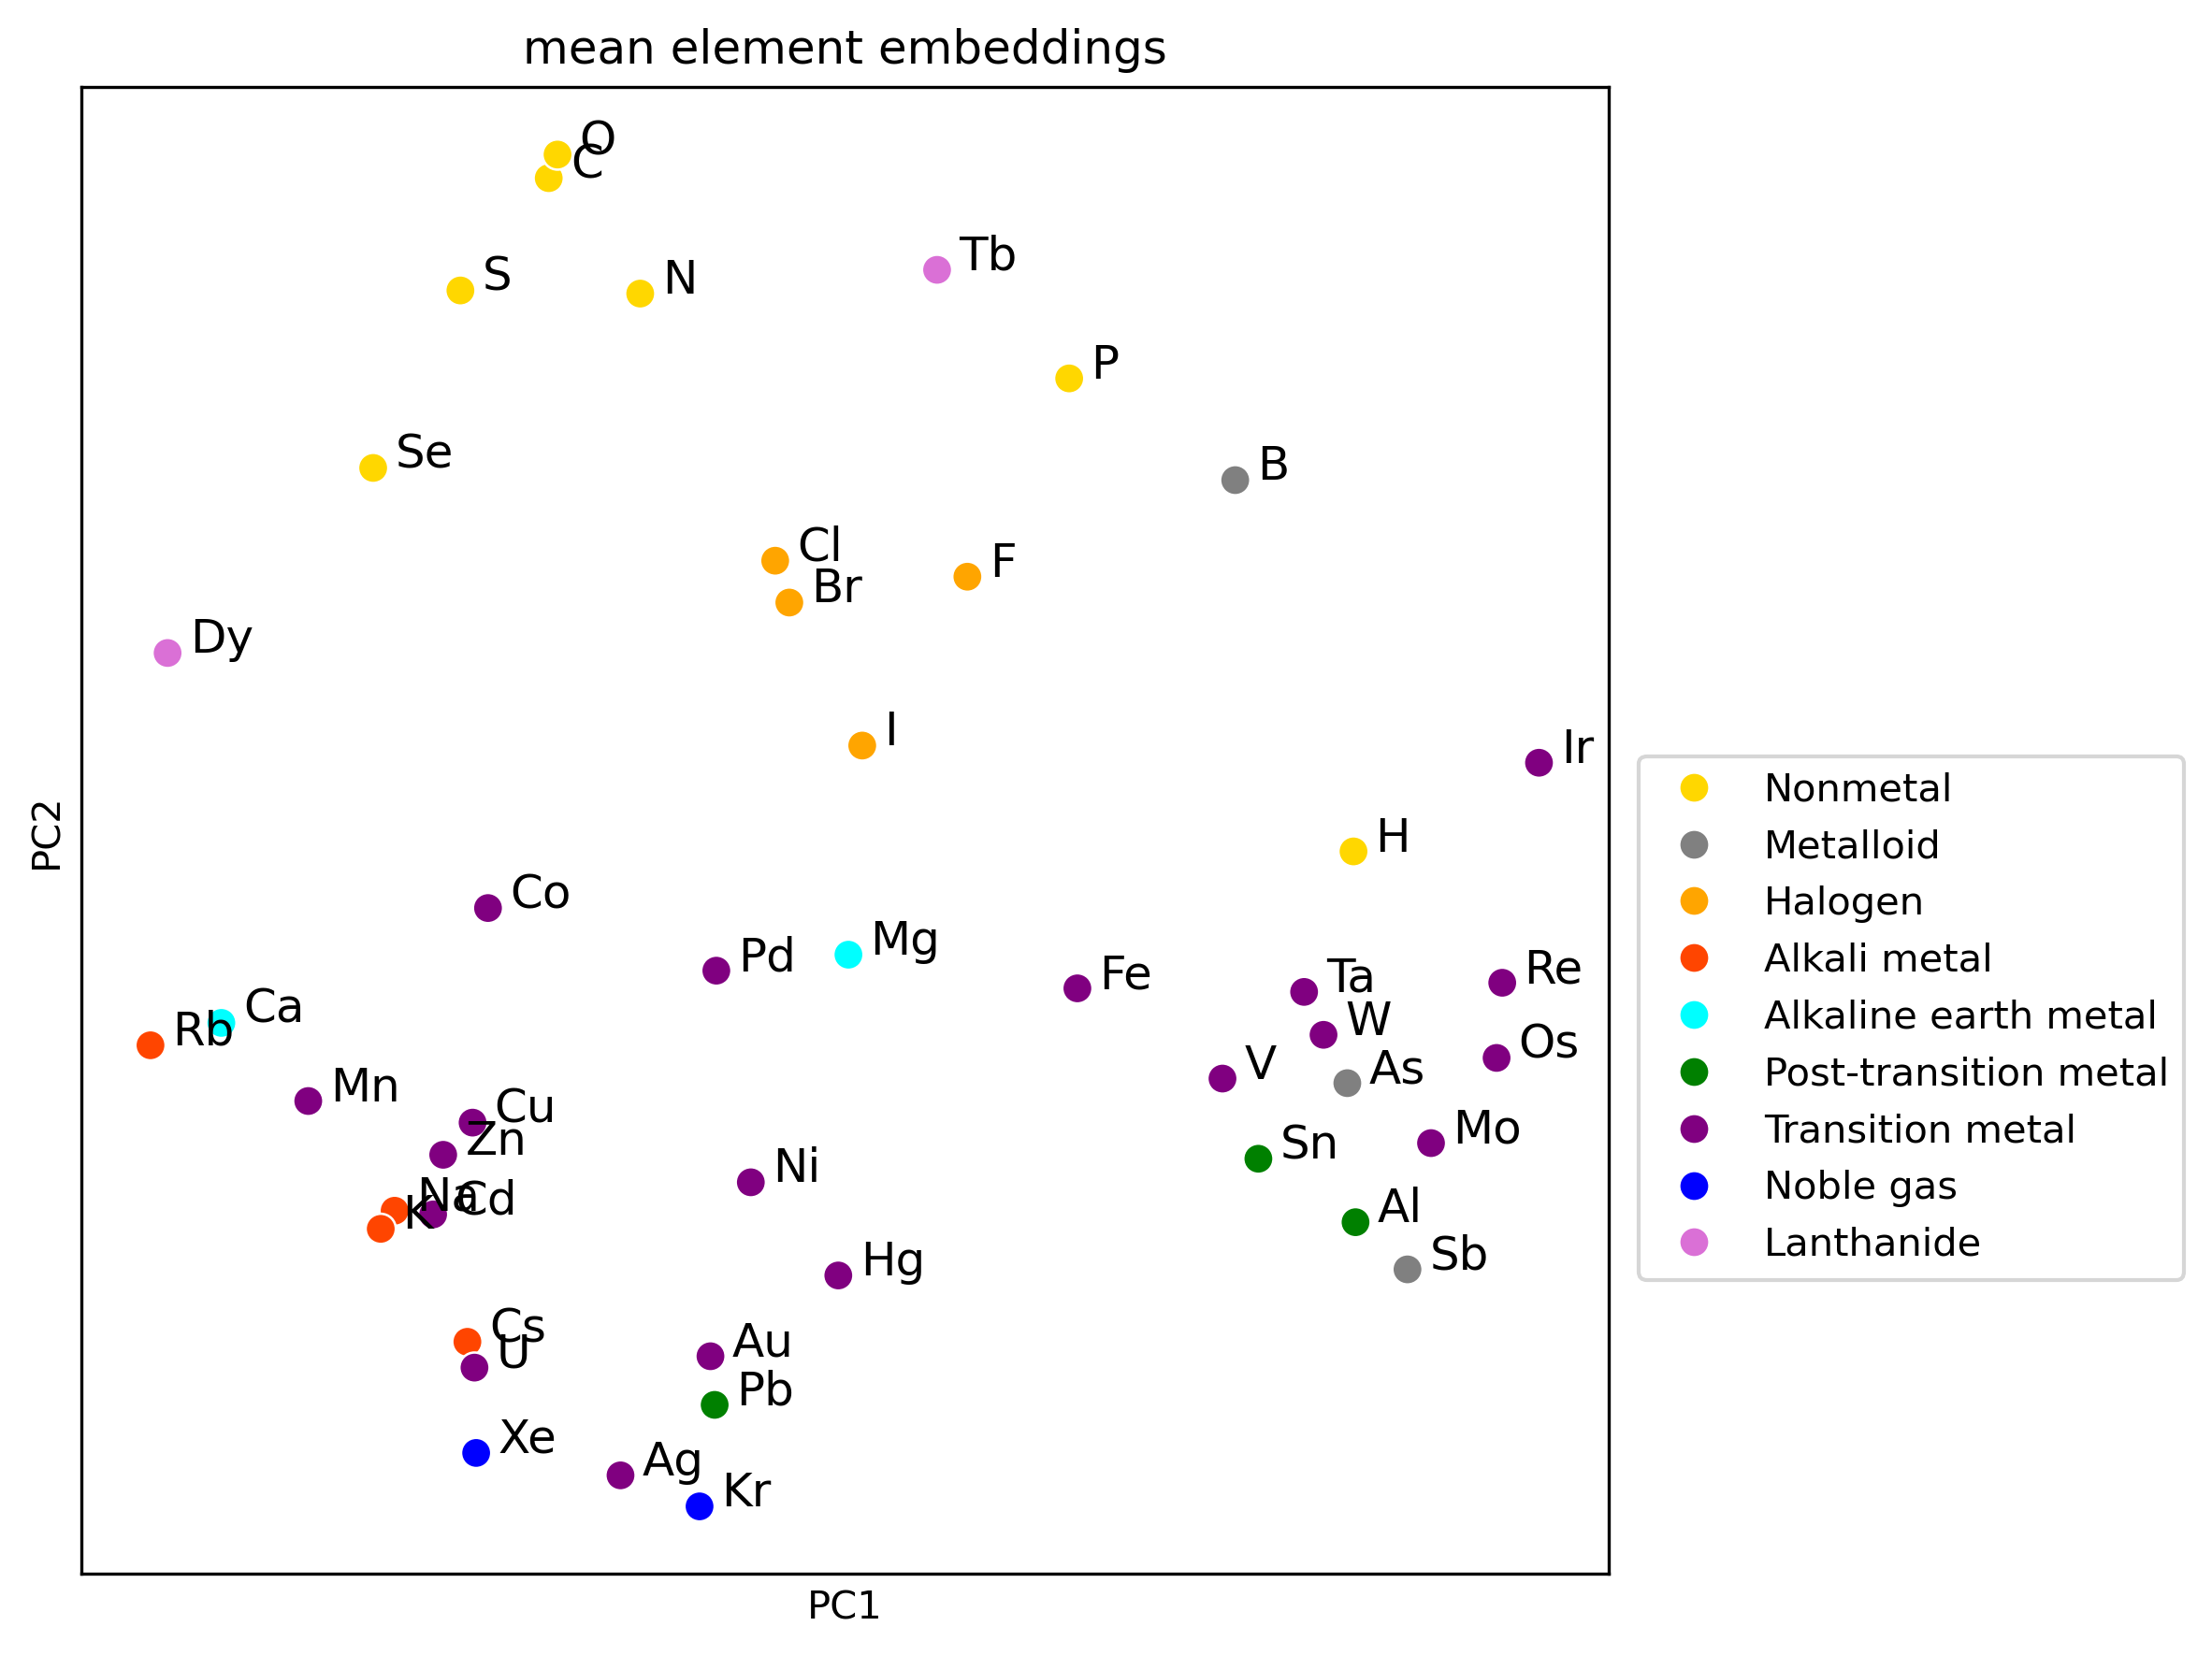

In [17]:
type_color = {
    'Nonmetal': '#FFD700',            # Gold
    'Metalloid': '#808080',           # Gray
    'Halogen': '#FFA500',             # Orange
    'Alkali metal': '#FF4500',        # OrangeRed
    'Alkaline earth metal': '#00FFFF',# Aqua
    'Transition metal': '#800080',    # Purple
    'Post-transition metal': '#008000',# Green
    'Noble gas': '#0000FF',           # Blue
    'Lanthanide': '#DA70D6'           # Orchid
}

plot_df = df #[df["source"] == "BioLiP"]
plt.figure(figsize=(8, 6), dpi=300)
# plot_df = plot_df.reset_index(drop=True)
ax = sns.scatterplot(
    data=plot_df,
    x="x",
    y="y",
    hue="type",
    alpha=1,
    s=60,
    palette=type_color,
)
ax.set(xlabel=None)
ax.set(ylabel=None)
for i in range(len(plot_df['x'])):
    plt.text(plot_df['x'][i] + 0.02,  # X position, with a slight offset to avoid overlapping the point
             plot_df['y'][i],       # Y position
             plot_df["element"][i], # + "_" + plot_df["source"][i],  # Text label
             fontsize=12)

plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0)
plt.title("mean element embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig("mean_element_embeddings.png", dpi=300)
plt.show()

# Block Embeddings

In [63]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

with open("/n/holylabs/LABS/mzitnik_lab/Users/afang/GET/data/tokenizer/vocabs/ps_vocab_300.txt", "r") as f:
    smilesstr = f.read()
frag_types = {}
for line in smilesstr.split("\n")[1:-1]:
    line = line.split("\t")
    smiles, count, freq = line
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        frag_types[smiles] = "unclassified fragment"
        continue
    is_amide = rdMolDescriptors.CalcNumAmideBonds(mol) > 0
    if is_amide:
        frag_types[smiles] = "amide"
        continue
    is_aromatic = rdMolDescriptors.CalcNumAromaticRings(mol) > 0
    is_hbond = (rdMolDescriptors.CalcNumHBA(mol) + rdMolDescriptors.CalcNumHBD(mol)) > 0
    if is_aromatic:
        if is_hbond:
            frag_types[smiles] = "aromatic ring with polar group"
            continue
        else:
            frag_types[smiles] = "aromatic ring"
            continue
    if is_hbond:
        frag_types[smiles] = "polar group"
        continue
    is_aliphatic_ring = rdMolDescriptors.CalcNumAliphaticRings(mol) > 0
    if is_aliphatic_ring:
        frag_types[smiles] = "aliphatic ring"
        continue
    is_heteroatom = rdMolDescriptors.CalcNumHeteroatoms(mol) > 0
    if is_heteroatom:
        frag_types[smiles] = "has heteroatom"
        continue
    frag_types[smiles] = "unclassified fragment"

from collections import Counter
Counter(frag_types.values())

[13:45:52] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[13:45:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 7 8 9
[13:45:52] non-ring atom 0 marked aromatic
[13:45:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[13:45:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[13:45:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[13:45:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[13:45:52] non-ring atom 0 marked aromatic
[13:45:52] Can't kekulize mol.  Unkekulized atoms: 2 3 4
[13:45:52] non-ring atom 0 marked aromatic
[13:45:52] non-ring atom 0 marked aromatic
[13:45:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[13:45:52] non-ring atom 0 marked aromatic
[13:45:52] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[13:45:52] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[13:45:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[13:45:52] non-ring atom 0 marked aromatic
[13:45:52] non-ring atom 0

Counter({'polar group': 88,
         'aromatic ring with polar group': 77,
         'unclassified fragment': 60,
         'amide': 35,
         'aromatic ring': 21,
         'has heteroatom': 15,
         'aliphatic ring': 4})

In [64]:
with open('block_projections.json', 'r') as f: 
    block_projections = json.load(f)
df = pd.DataFrame(block_projections)
block_category = []

VOCAB.load_tokenizer('PS_300')
for block in df['block_type']:
    block = (VOCAB.abrv_to_symbol(block), block)
    if block in VOCAB.aas:
        block_category.append('amino_acid')
    elif block in VOCAB.bases:
        block_category.append('base')
    elif block in VOCAB.sms:
        block_category.append('elements')
    elif block in VOCAB.frags:
        block_category.append(frag_types[block[-1]])
    else:
        block_category.append('unknown')
        print("Unknown block:", block)
df['block_category'] = block_category
df

,x,y,block_index,block_type,block_category
0,0.423756,0.036498,4,GLY,amino_acid
1,0.531648,0.037314,5,ALA,amino_acid
2,0.584398,0.008646,6,VAL,amino_acid
3,0.614864,0.000448,7,LEU,amino_acid
4,0.594271,-0.000811,8,ILE,amino_acid
...,...,...,...,...,...
348,-0.058343,-0.122695,434,c=O,unclassified fragment
349,0.094938,-0.199025,435,C=O,polar group
350,0.082733,-0.175777,437,C=N,polar group
351,-0.045845,-0.159493,438,O=P,polar group


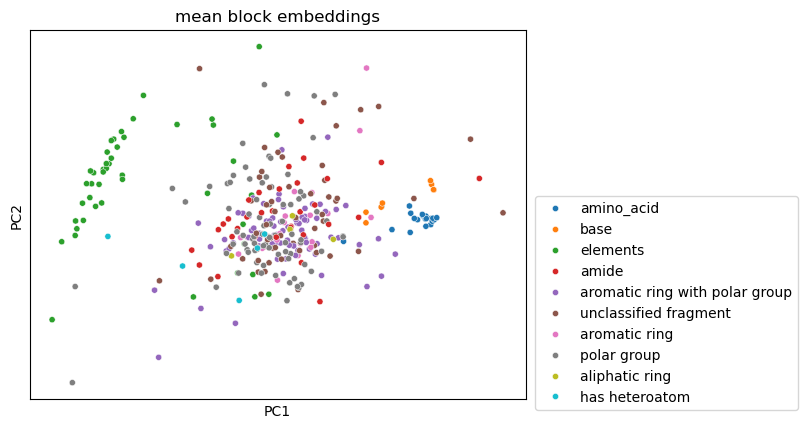

In [67]:
ax = sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="block_category",
    alpha=1,
    s=20,
    # palette=type_color,
)
ax.set(xlabel=None)
ax.set(ylabel=None)
# for i in range(len(df['x'])):
#     plt.text(df['x'][i] + 0.01,  # X position, with a slight offset to avoid overlapping the point
#              df['y'][i],       # Y position
#              df["block_type"][i],  # Text label
#              fontsize=9)

plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0)
plt.title("mean block embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Amino acid embeddings

In [3]:
aa_type_color_dict = {
 'polar': '#1E90FF', 'sulfur': '#FFD700',     
 'hydrophobic': '#8B4513',
 'aromatic': '#800080',
 'positive': '#00FF00',   
 'negative': '#FF4500',
 "unknown": "#000000",
}

AA_TYPE = {
 'GLY': 'hydrophobic',
 'PRO': 'hydrophobic',
 'ALA': 'hydrophobic',
 'ILE': 'hydrophobic',
 'LEU': 'hydrophobic',
 'VAL': 'hydrophobic',
 'ASN': 'polar',
 'CYS': 'polar',
 'GLN': 'polar',
 'SER': 'polar',
 'THR': 'polar',
 'PHE': 'aromatic',
 'TYR': 'aromatic',
 'TRP': 'aromatic',
 'HIS': 'positive', # and polar, aromatic
 'ARG': 'positive',
 'LYS': 'positive',
 'ASP': 'negative',
 'GLU': 'negative',
 'MET': 'sulfur',
}

In [4]:
import json
with open('aa_block_projections.json', 'r') as f: 
    aa_block_projections = json.load(f)
df = pd.DataFrame(aa_block_projections)
df['aa_category'] = [AA_TYPE.get(block, "unknown") for block in df['block_type']]
df

,x,y,block_index,block_type,aa_category
0,0.423756,0.036498,4,GLY,hydrophobic
1,0.531649,0.037314,5,ALA,hydrophobic
2,0.584399,0.008646,6,VAL,hydrophobic
3,0.614864,0.000449,7,LEU,hydrophobic
4,0.594272,-0.000811,8,ILE,hydrophobic
5,0.614845,-0.017427,9,PHE,aromatic
6,0.595969,0.007692,10,TRP,aromatic
7,0.620825,-0.007304,11,TYR,aromatic
8,0.534713,-0.040194,12,ASP,negative
9,0.463633,-0.031953,13,HIS,positive


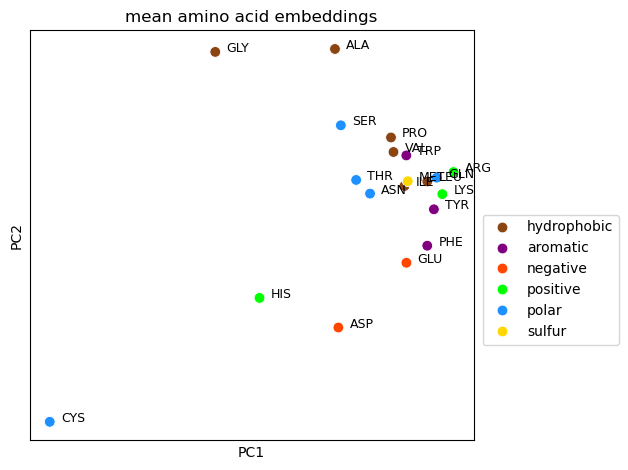

In [7]:
ax = sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="aa_category",
    alpha=1,
    s=60,
    palette=aa_type_color_dict,
)
ax.set(xlabel=None)
ax.set(ylabel=None)
for i in range(len(df['x'])):
    plt.text(df['x'][i] + 0.01,  # X position, with a slight offset to avoid overlapping the point
             df['y'][i],       # Y position
             df["block_type"][i],  # Text label
             fontsize=9)

plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0)
plt.title("mean amino acid embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig("mean_aa_embeddings.png", dpi=300)
plt.show()